<a href="https://colab.research.google.com/github/jan-de-trop/Cancer-Classification/blob/main/Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <h1> CANCER CLASSIFICATION <h1>

We aim to build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. 

### Importing the libraries

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from prettytable import PrettyTable
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set()


### Loading the Dataset and Preprocessing

In [2]:
np.random.seed(10)
df = pd.read_csv('cancer_genes.csv', index_col=0)
print(df.head())
X = df.drop(['Cancer_type'],axis=1)
y = df['Cancer_type']
X_train , X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, stratify=y, random_state = 109)

   Cancer_type  AFFX-BioB-5_at  ...  M71243_f_at  Z78285_f_at
0          0.0          -214.0  ...        191.0        -37.0
1          0.0          -135.0  ...        126.0        -91.0
2          0.0          -106.0  ...         56.0        -25.0
3          0.0           -72.0  ...        369.0        -42.0
4          0.0          -413.0  ...        781.0         20.0

[5 rows x 7130 columns]


In [3]:
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


In [4]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,-115.860969,-160.846155,26.545301,209.733439,-248.992903,-405.422569,-24.135140,-188.491329,74.777098,97.436777,-108.236558,-639.448894,-586.435698,-177.897188,122.012925,178.858124,-86.310922,-321.362785,26035.249707,19.234997,143.676548,-78.265259,12.593494,-210.564369,97.025266,-74.935006,-117.651460,-2.989531,-7.087611,-22.894708,-262.514398,16.081432,-678.746425,-251.903950,-245.516605,-80.479524,287.187964,712.984206,2262.523373,500.221226,...,271.204348,-476.184929,325.265555,343.681520,398.751955,603.685759,18214.010460,16415.005292,828.811667,270.527212,89.907783,13442.163946,10669.804658,214.390467,4146.339604,-206.878783,22.771989,307.550360,9.356316,199.443291,29.300521,53.430456,-117.836062,267.567266,96.975982,209.307550,280.528936,-281.980641,-1621.634815,747.235049,161.766492,707.377318,4.198787,421.466477,-50.023954,819.053113,329.803212,8.803791,507.250039,-24.377549
std,170.571929,188.676919,207.781982,202.987246,207.328054,261.112412,535.143398,163.077167,174.693115,358.897719,360.342558,460.469509,524.175507,223.401941,271.270002,253.488236,139.577783,358.674276,19848.699511,237.157961,243.723986,112.746904,73.457409,422.958577,793.336435,108.084971,121.150727,140.490868,89.903152,101.362899,236.280898,113.612919,960.393519,459.507052,530.780244,892.097747,545.051870,1215.436253,7578.576176,5690.932400,...,183.732244,1450.663780,354.512134,1365.309098,285.424557,1149.340159,9502.264229,7407.587829,1010.834206,292.288775,434.344925,7941.247160,6165.482564,558.433401,6259.247756,167.347466,139.552694,419.196565,95.659371,207.223586,89.075120,164.487957,350.045159,259.107853,179.519477,177.861910,331.022515,288.061960,1584.770322,1103.824972,165.152970,526.644408,152.401188,589.914084,106.864078,814.898058,367.788891,85.397644,939.394188,71.102874
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,-1441.928478,-1927.724207,-2302.6

From the data, severe differences can be observed in the measurements from one gene to the next. Normalisation is used to scale the data between 0 and 1 to account for these differences.

In [5]:
min_vals = X_train.min()
max_vals = X_train.max()

X_train = (X_train - min_vals)/(max_vals - min_vals)
X_test = (X_test - min_vals)/(max_vals - min_vals)

### Dimensionality Reduction

<h4> The curse of Dimensionality <h4>
<p>There are 7129 genes and 751 samples. This can lead to data imbalance and can cause overfitting. <p>
<p> Dimensionality reduction helps by determining the most important parameters and use only those for prediction. We use the Welch's t-test. (https://en.wikipedia.org/wiki/Welch)  <p>

In [6]:
# your code here 
s1 = X_train[y_train==0]
s2 = X_train[y_train==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))

t_stats = t_stats[np.argsort(-1*np.abs(t_stats))]
best_pred = t_stats.index[0]
top10 = t_stats.index[:10]
print("The best predictor to discriminate between the 2 cancer classes is",best_pred, end="\n\n")
print("The top 10 best predictors are", list(top10), sep = "\t")

The best predictor to discriminate between the 2 cancer classes is M31523_at

The top 10 best predictors are	['M31523_at', 'X95735_at', 'M84526_at', 'X61587_at', 'U50136_rna1_at', 'X17042_at', 'U29175_at', 'Y08612_at', 'Z11793_at', 'X76648_at']


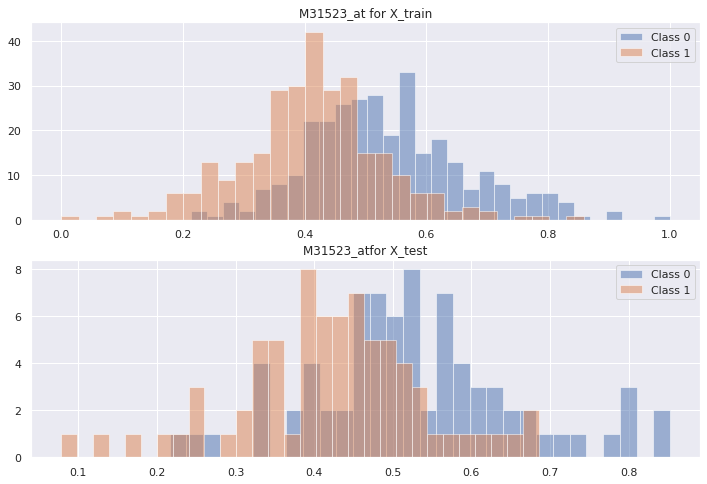

In [7]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.hist( X_train[y_train==0][best_pred], alpha = 0.5, bins=30, label='Class 0')
plt.hist( X_train[y_train==1][best_pred], alpha = 0.5, bins=30, label='Class 1')
plt.title(best_pred + " for X_train")
plt.legend()

plt.subplot(212)
plt.hist( X_test[y_test==0][best_pred], alpha = 0.5,bins=30,label='Class 0')
plt.hist( X_test[y_test==1][best_pred], alpha = 0.5,bins=30, label='Class 1')
plt.title(best_pred + "for X_test")
plt.legend();

### Predicting the cancer type

In [8]:
res = []
logreg = LogisticRegression(C=100000, solver='lbfgs')
logreg.fit(X_train[[best_pred]], y_train) 

y_train_pred_logreg = logreg.predict(X_train[[best_pred]])
y_test_pred_logreg = logreg.predict(X_test[[best_pred]])

train_score_logreg = accuracy_score(y_train, y_train_pred_logreg)
test_score_logreg = accuracy_score(y_test, y_test_pred_logreg)

print("Train score:", train_score_logreg, "Test score:", test_score_logreg)

res.append([['Logistic Regression train', train_score_logreg], ['Logistic Regression test', test_score_logreg]] )
print(res)

Train score: 0.7071547420965059 Test score: 0.7086092715231788
[[['Logistic Regression train', 0.7071547420965059], ['Logistic Regression test', 0.7086092715231788]]]


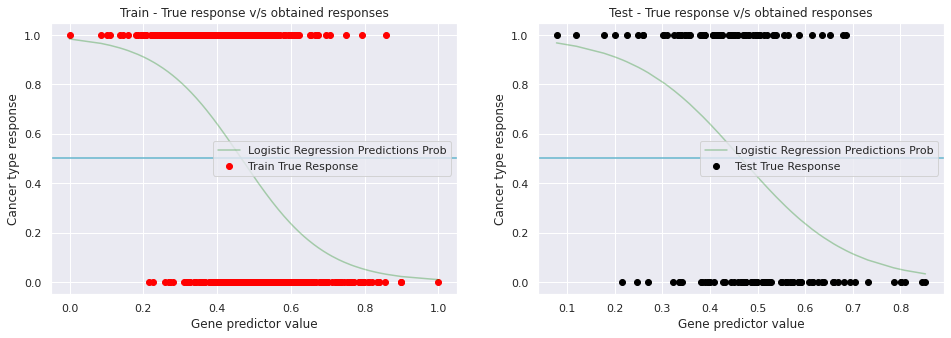

In [10]:
y_train_pred_logreg_prob = logreg.predict_proba(X_train[[best_pred]])[:,1]
y_test_pred_logreg_prob = logreg.predict_proba(X_test[[best_pred]])[:,1]

fig, ax = plt.subplots(1,2, figsize=(16,5))
sort_index = np.argsort(X_train[best_pred].values)

# plotting true binary response
ax[0].scatter(X_train[best_pred].iloc[sort_index].values, y_train.iloc[sort_index].values, color='red', label = 'Train True Response')

# plotting logreg prob output
ax[0].plot(X_train[best_pred].iloc[sort_index].values, y_train_pred_logreg_prob[sort_index], alpha=0.3,  \
         color='green', label = 'Logistic Regression Predictions Prob')

ax[0].axhline(0.5, c='c')
ax[0].legend()
ax[0].set_title('Train - True response v/s obtained responses')
ax[0].set_xlabel('Gene predictor value')
ax[0].set_ylabel('Cancer type response');

# Test
sort_index = np.argsort(X_test[best_pred].values)

# plotting true binary response
ax[1].scatter(X_test[best_pred].iloc[sort_index].values, y_test.iloc[sort_index].values, color='black', label = 'Test True Response')


# plotting logreg prob output
ax[1].plot(X_test[best_pred].iloc[sort_index].values, y_test_pred_logreg_prob[sort_index], alpha=0.3,  \
         color='green', label = 'Logistic Regression Predictions Prob')

ax[1].axhline(0.5, c='c')
ax[1].legend()
ax[1].set_title('Test - True response v/s obtained responses')
ax[1].set_xlabel('Gene predictor value')
ax[1].set_ylabel('Cancer type response');

Further improvements could involve:

1) Working with bigger sample for more accurate prediction.  

2) Using Neural Networks to better capture the patterns.